<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
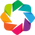

2023-09-30 17:41:36,090 - gaia.gaia.config - INFO - no dataset provided ... you must be loading it from an existing model


In [2]:
import holoviews as hv
hv.extension("bokeh")
import hvplot.pandas
import pandas as pd
from pathlib import Path
import sys
sys.path.append("/proj/gaia-climate/team/kirill/gaia-surrogate")
from gaia.training import load_hparams_file


In [4]:
import tqdm.auto as tqdm

In [19]:
def get_metrics(model_dir, dataset = "spcam"):

    try:
        metrics = pd.read_json(next(Path(model_dir).glob(f"*{dataset}*"))).T.squeeze()
    except Exception:
        return pd.Series()
    hparams = load_hparams_file(model_dir)
    metrics["subsample"] = int(hparams["dataset_params"]["train"].get("subsample",1))
    metrics["batch_size"] = int(hparams["dataset_params"]["train"].get("batch_size",1))

    metrics["is_finetuned"]  = int(hparams.get("is_finetuned",False))
    metrics["base_model"] = "random"
    metrics["samples"] = 24 * 96 * 144 * 54 // metrics["subsample"]
    metrics["lr"] = hparams["lr"]
    
    if "base_cam4" in str(model_dir):
        # return pd.Series()
        metrics["is_finetuned"] = True
        metrics["samples"] = 10

    # if "base_spacm" in str(model_dir):
    #     metrics["base_model"] = "cam4" 
    #     # metrics["base_model"] = "cam4"
    #     # metrics["is_finetuned"] = True
    #     # metrics["subsample"] = 

    
    if metrics["is_finetuned"]:
        metrics["base_model"] = "cam4"        
        
        
    return metrics

data = pd.concat([get_metrics(f).to_frame().T for f in Path("lightning_logs").glob("*")]).dropna()
data = data.iloc[:,1:]
data.columns = [c.replace("test_skill_ave_trunc_","") for c in data.columns]

min_level = 11

data["PTEQ"] = data.loc[:,[c for c in data.columns if "PTEQ_" in c]].iloc[:,min_level:].mean(1)
data["PTTEND"] = data.loc[:,[c for c in data.columns if "PTTEND_" in c]].mean(1)




In [14]:
from gaia.plot import levels, levels26


In [23]:
pd.Series(levels).round(2)

0       3.64
1       7.59
2      14.36
3      24.61
4      38.27
5      54.60
6      72.01
7      87.82
8     103.32
9     121.55
10    142.99
11    168.23
12    197.91
13    232.83
14    273.91
15    322.24
16    379.10
17    445.99
18    524.69
19    609.78
20    691.39
21    763.40
22    820.86
23    859.53
24    887.02
25    912.64
26    936.20
27    957.49
28    976.33
29    992.56
dtype: float64

In [3]:
data = data.query("batch_size>=64")#.subsample.unique().astype(int)

In [9]:
# data.subsample.drop_duplicates().astype(int).to_csv("subsample.csv")

In [5]:
data.subsample.value_counts().sort_index()

subsample
1.0          3
8.0          2
16.0         2
32.0         2
64.0         2
128.0        2
256.0        2
512.0        2
1024.0       2
2048.0      42
4096.0      42
8192.0      42
16384.0     41
32768.0     42
65536.0     42
131072.0    42
262144.0    42
Name: count, dtype: int64

In [21]:
def plot_one_with_error_bars(base_model, metric):
    temp1 = data.query(f"base_model=='{base_model}'")
    temp = temp1.groupby(["samples"])[metric].agg(["mean","std"]).rename(columns = {"mean":metric})
    return  hv.Scatter(temp1, kdims=["samples"], vdims=[metric], label = base_model).opts(size = 2)*\
    hv.Curve(temp.reset_index(), kdims=["samples"], vdims=[metric], label = base_model).opts(logx=True,line_width=.5, show_grid = True).redim.range(**{metric:(0,1)})
    # hv.ErrorBars(temp.reset_index(), kdims=["samples"], vdims=[metric,"std"], label = base_model).opts(line_width=.5)*\

    # hv.Scatter(temp.reset_index(), kdims=["samples"], vdims=[metric], label = base_model).opts(size = 3)*\



out = hv.Layout([(plot_one_with_error_bars("cam4", v)*plot_one_with_error_bars("random", v)).opts(legend_position = "bottom_right") for v in ["PRECT","PTTEND","PTEQ"]])
hv.save(out,"plot_finetune.html")
out


/home/kirill.trapeznikov/miniconda3/envs/torch2/lib/python3.10/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/home/kirill.trapeznikov/miniconda3/envs/torch2/lib/python3.10/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/home/kirill.trapeznikov/miniconda3/envs/torch2/lib/python3.10/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

:Layout
   .Overlay.I   :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PRECT)
      .Curve.Cam4     :Curve   [samples]   (PRECT)
      .Scatter.Random :Scatter   [samples]   (PRECT)
      .Curve.Random   :Curve   [samples]   (PRECT)
   .Overlay.II  :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTTEND)
      .Curve.Cam4     :Curve   [samples]   (PTTEND)
      .Scatter.Random :Scatter   [samples]   (PTTEND)
      .Curve.Random   :Curve   [samples]   (PTTEND)
   .Overlay.III :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ)
      .Curve.Cam4     :Curve   [samples]   (PTEQ)
      .Scatter.Random :Scatter   [samples]   (PTEQ)
      .Curve.Random   :Curve   [samples]   (PTEQ)

In [8]:
var = "PTEQ"
num_levels = 30
out = hv.Layout([(plot_one_with_error_bars("cam4", f"{var}_{i:02}")*plot_one_with_error_bars("random", f"{var}_{i:02}")).opts(legend_position = "bottom_right") for i in range(num_levels)]).cols(5)
hv.save(out,f"plot_finetune_{var}.html")
out

/home/kirill.trapeznikov/miniconda3/envs/torch2/lib/python3.10/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/home/kirill.trapeznikov/miniconda3/envs/torch2/lib/python3.10/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/home/kirill.trapeznikov/miniconda3/envs/torch2/lib/python3.10/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

:Layout
   .Overlay.I      :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_00)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_00)
      .Scatter.Random :Scatter   [samples]   (PTEQ_00)
      .Curve.Random   :Curve   [samples]   (PTEQ_00)
   .Overlay.II     :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_01)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_01)
      .Scatter.Random :Scatter   [samples]   (PTEQ_01)
      .Curve.Random   :Curve   [samples]   (PTEQ_01)
   .Overlay.III    :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_02)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_02)
      .Scatter.Random :Scatter   [samples]   (PTEQ_02)
      .Curve.Random   :Curve   [samples]   (PTEQ_02)
   .Overlay.IV     :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_03)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_03)
      .Scatter.Random :Scatter   [samples]   (PTEQ_03)
      .Curve.Random   :Curve   [samples]   (PTEQ_03)
   .Overlay.V      :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_04)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_04)
      .Scatter.Random :Scatter   [samples]   (PTEQ_04)
      .Curve.Random   :Curve   [samples]   (PTEQ_04)
   .Overlay.VI     :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_05)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_05)
      .Scatter.Random :Scatter   [samples]   (PTEQ_05)
      .Curve.Random   :Curve   [samples]   (PTEQ_05)
   .Overlay.VII    :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_06)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_06)
      .Scatter.Random :Scatter   [samples]   (PTEQ_06)
      .Curve.Random   :Curve   [samples]   (PTEQ_06)
   .Overlay.VIII   :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_07)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_07)
      .Scatter.Random :Scatter   [samples]   (PTEQ_07)
      .Curve.Random   :Curve   [samples]   (PTEQ_07)
   .Overlay.IX     :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_08)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_08)
      .Scatter.Random :Scatter   [samples]   (PTEQ_08)
      .Curve.Random   :Curve   [samples]   (PTEQ_08)
   .Overlay.X      :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_09)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_09)
      .Scatter.Random :Scatter   [samples]   (PTEQ_09)
      .Curve.Random   :Curve   [samples]   (PTEQ_09)
   .Overlay.XI     :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_10)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_10)
      .Scatter.Random :Scatter   [samples]   (PTEQ_10)
      .Curve.Random   :Curve   [samples]   (PTEQ_10)
   .Overlay.XII    :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_11)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_11)
      .Scatter.Random :Scatter   [samples]   (PTEQ_11)
      .Curve.Random   :Curve   [samples]   (PTEQ_11)
   .Overlay.XIII   :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_12)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_12)
      .Scatter.Random :Scatter   [samples]   (PTEQ_12)
      .Curve.Random   :Curve   [samples]   (PTEQ_12)
   .Overlay.XIV    :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_13)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_13)
      .Scatter.Random :Scatter   [samples]   (PTEQ_13)
      .Curve.Random   :Curve   [samples]   (PTEQ_13)
   .Overlay.XV     :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_14)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_14)
      .Scatter.Random :Scatter   [samples]   (PTEQ_14)
      .Curve.Random   :Curve   [samples]   (PTEQ_14)
   .Overlay.XVI    :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_15)
      .Curve.Cam4     :Curve   [samples]   (PTEQ_15)
      .Scatter.Random :Scatter   [samples]   (PTEQ_15)
      .Curve.Random   :Curve   [samples]   (PTEQ_15)
   .Overlay.XVII   :Overlay
      .Scatter.Cam4   :Scatter   [samples]   (PTEQ_16)
     

In [ ]:

# pd.Series(np.random.randint(1000,size=20)).to_csv("seed.csv",index =False)
# seeds = pd.read_csv("seed.csv").iloc[:,0]
# list(seeds)

In [6]:
metrics = "PRECT,PRECC,PTTEND,PTEQ".split(",")

def plot_one(metric):
    temp = data.sort_values(["base_model","samples"])
    return temp.hvplot.line(x = "samples", y = metric, groupby = "base_model", logx = True, line_width = .5, width = 400, grid = True)*\
    temp.hvplot.scatter(x = "samples", y = metric, groupby = "base_model", logx = True, padding = .1)

plots = hv.Layout([plot_one(metric).overlay("base_model").opts(legend_position = "bottom_right", title=f"skill {metric}") for metric in metrics])
plots = plots.cols(2)
plots

:Layout
   .NdOverlay.I   :NdOverlay   [base_model]
      :Overlay
         .Curve.I   :Curve   [samples]   (PRECT)
         .Scatter.I :Scatter   [samples]   (PRECT)
   .NdOverlay.II  :NdOverlay   [base_model]
      :Overlay
         .Curve.I   :Curve   [samples]   (PRECC)
         .Scatter.I :Scatter   [samples]   (PRECC)
   .NdOverlay.III :NdOverlay   [base_model]
      :Overlay
         .Curve.I   :Curve   [samples]   (PTTEND)
         .Scatter.I :Scatter   [samples]   (PTTEND)
   .NdOverlay.IV  :NdOverlay   [base_model]
      :Overlay
         .Curve.I   :Curve   [samples]   (PTEQ)
         .Scatter.I :Scatter   [samples]   (PTEQ)

In [ ]:
data

In [ ]:
metrics = "PRECT,PRECC,PTTEND,PTEQ".split(",")

def plot_one(metric):
    temp = data.sort_values(["base_model","samples"])
    return temp.hvplot.line(x = "samples", y = metric, groupby = "base_model", logx = True, line_width = .5, width = 400, grid = True)*\
    temp.hvplot.scatter(x = "samples", y = metric, groupby = "base_model", logx = True, padding = .1)

plots = hv.Layout([plot_one(metric).overlay("base_model").opts(legend_position = "bottom_right", title=f"skill {metric}") for metric in metrics])
plots = plots.cols(5)
plots